In [1]:
import numpy as np
import csv
import matplotlib.pyplot as mp
import pandas as pd


                    #################   System parameters   #################

# old test data
min_optimal_UR = 10
max_optimal_UR = 80
UR_critical_upper_bound = 85
mean_price = 165
prices_range_ratio = 0.1

alfa = 0.7


# usable data
validation_period = 28
CF_test_period = 180
csv_data = np.zeros(CF_test_period)
x_ax = np.arange(CF_test_period)
filename = 'shib-usd.csv' #'shib-usd.csv' # 'fei-usd-max.csv' # 'rai-usd-max.csv' 'eth-usd-max.csv' 'btc-usd-max.csv'
Title = "Shiba-Inu" # "Shiba-Inu", "RAI", "FEI", "ETH"

sigma_event = 3

In [16]:
                    #################   Calculation functoins   #################

def returns_calculation(P):
    returns = np.zeros(P.size-1)
    for _ in range(1, P.size):
        returns[_-1] = (P[_]/P[_-1])-1
    return returns

def STD_calculation(X):
    return np.std(X)

def random_common_week(P, period = 7):
    Prices = np.random.randint(mean_price * (1 - prices_range_ratio), mean_price * (1 + prices_range_ratio), size=period)
    return np.hstack((P[period:],Prices))

def random_week(sigma_event, P, period = 7):
    Prices = np.random.randint(mean_price * (1 - (sigma_event*prices_range_ratio)), mean_price * (1 + (sigma_event*prices_range_ratio)), size=period)
    return np.hstack((P[period:],Prices))

def daily_change(P, period = 1):
    Prices = np.random.randint(mean_price * (1 - (sigma_event*prices_range_ratio)), mean_price * (1 + (sigma_event*prices_range_ratio)), size=period)
    return np.hstack((P[period:], Prices))

def raw_formula(sigm, crash_sigm, CF_acc, liq_rate=0):

    ###
    # This approach operates with returns
    # Hard liquidation (50 %)
    ###
    price_ratio = 10
    CF = (1-(2*(crash_sigm+liq_rate/100)+1)*sigm)
    Debt = CF*price_ratio
    liq_rate = 1+(liq_rate/100)
    #Upd_L = CF*(price_ratio*(1-(crash_sigm*sigm)))
    Liq = 0.5*Debt
    Liq_a2 = Liq/(price_ratio*(1-(crash_sigm*sigm)))
    Up = 1-(liq_rate*Liq_a2)
    Rest = Up*CF*(price_ratio*(1-(crash_sigm*sigm)))

    alternative = Up*CF_acc*(price_ratio*(1-(crash_sigm*sigm)))
    #print(" CF = {:.3f}, debt = {:.3f}, rest = {:.3f}".format(CF, Debt/2, Rest))
    #print(" Alternative rest = {:.3f}".format(alternative))
    return CF

def CF_calculation(Prices, nsigma):
    P_init = Prices[-1]
    P_nsgima = np.mean(Prices) - (nsigma * STD_calculation(Prices))
    CF = ((2 / P_init) - (1 / P_nsgima)) #* (2 / np.mean(Prices))
    print("CF = {:.3f}".format(CF))
    return CF

def TWAP_manipulation_cost(e, pair_liquidity):
    return pair_liquidity*(np.sqrt(1+e)+(1/(np.sqrt(1+e))) - 2)

def COA_CF(sigm, crash_sigm, discount):

    return (1-(2*(crash_sigm+discount/100)+1)*sigm)

In [20]:
pB = 1500
TVL = 10e6 # in USD
e = 0.5
tmp_COA = TWAP_manipulation_cost(e, TVL)
print("COA in USD price of B asset", tmp_COA*pB/1e6)

COA in USD price of B asset 618.6217847897279


In [21]:
# Discount model #

Max_rev = 1e6

In [3]:
                             ################# CSV prices file parsing #####################

a = np.genfromtxt(filename, delimiter=',')
lastN = a[-180:]
lastN_prices = np.zeros(lastN.shape[0])

for _ in range(lastN.shape[0]):
    lastN_prices[_] = lastN[_][1]

# mp.plot(x_ax, lastN_prices)
# mp.xlabel("days")                                                                               # plot prices for comparison
# mp.ylabel("price in USD")
# mp.title("{:.15s} Price". format(Title))
# mp.show()

In [4]:

                                #################   Simulation    #################

# Prices generation
#Prices = np.random.randint(mean_price*(1-prices_range_ratio), mean_price*(1+prices_range_ratio), size=validation_period)
#PricesX96 = Prices*(2**96)
returns = returns_calculation(lastN_prices[-28:])
std_returns = STD_calculation(returns)

Res_acc = CF_calculation(lastN_prices[-28:]/(np.mean(lastN_prices)), sigma_event)
Res_raw = raw_formula(std_returns, 3, Res_acc)


Raw_plot = list()
update_period = 5
for i in range((CF_test_period-validation_period)//update_period):
    Prices = lastN_prices[i*update_period:(i*update_period)+validation_period]

    returns = returns_calculation(Prices)#[-28:])
    std_returns = STD_calculation(returns)

    #Res_acc = CF_calculation(Prices[-28:] / (np.mean(Prices)), sigma_event)
    Res_raw = raw_formula(std_returns, 3, Res_acc)

    # absolute constraint #
    # if Raw_plot != [] and Res_raw > 1.1*Raw_plot[-1][-1]:
    #     Res_raw = 1.1*Raw_plot[-1][-1]

    Raw_plot.append([Res_raw]*update_period)


Raw_g = np.zeros(len(Raw_plot)*len(Raw_plot[0]))
m = 0
for j in range(len(Raw_plot)):
    for i in range(len(Raw_plot[0])):
        Raw_g[m] = Raw_plot[j][i]
        m+=1

        
        # Need to revise
#np.save("Absolute_constraint", Raw_g)



CF = 0.754


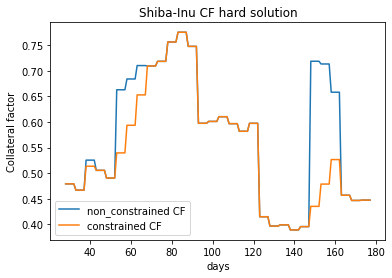

In [5]:
############################# CF curve analysis ###########################################

abs_const = np.load("Absolute_constraint.npy")
fig, ax = mp.subplots()
Non_constrained, = ax.plot(x_ax[validation_period:150+validation_period], Raw_g, label = "non_constrained CF")
Constrained, = ax.plot(x_ax[validation_period:150+validation_period], abs_const, label = "constrained CF")
mp.xlabel("days")
mp.ylabel("Collateral factor")
mp.title("{:.15s} CF hard solution".format(Title))
ax.legend(handles = [Non_constrained, Constrained])
mp.show()


#############################

# start = 28
# Rss = np.zeros(CF_test_period-validation_period)
# for kk in range(0, CF_test_period-validation_period, update_period):
#     Rss[start] = Raw_g[kk:kk+validation_period]
#     start += 1

# mp.plot(x_ax[:(CF_test_period-validation_period)], Rss)
# mp.show()